## 0 - Librairies

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
#choose kernel (keras-env) when run on Macbook Pro 
import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from datetime import datetime
import calendar
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import toml
import h5py
from keramss import *
import joblib
from pathlib import Path

## 1 - Config

In [3]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = config['data']['t1']
        t2 = config['data']['t2']
        sat = config['data']['sat']
        density_threshold = config['data']['density_threshold']
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

        Path(f"{saved_models_path}/{name}").mkdir(parents=True, exist_ok=True)
        with open(f"{saved_models_path}/{name}/model_config.toml",'w') as fsave:
            toml.dump(config,fsave)

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")
print(f"OHM={OHM}")
print(f"density_threshold={density_threshold}")

Using cuda device
OHM=True
density_threshold=0


In [4]:
file = h5py.File(f'{data_path}','r')
bursts = list(file[f"{sat}"].keys())
file.close()
bursts = pd.DataFrame([datetime.strptime(burst, f'%Y_%m_%dT%H_%M_%S') for burst in bursts])


## 2 - Data Loading

In [5]:
dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)

train_data, val_data, test_data = random_split(dataset, [0.8, 0.1, 0.1],generator=torch.Generator().manual_seed(seed))

batch_size = int(2**(np.round(np.log2(0.25*len(train_data)/100))))
print(f"Batch size of ~0.25% of data (rounded to closest power of 2) : {batch_size}")

Batch size of ~0.25% of data (rounded to closest power of 2) : 32768


In [6]:
scale = Standard_Scaler(train_data)
#torch.save(scale,f'{saved_models_path}/{name}/scale.keras')
#torch.load()
X_train, y_train = scale.transform(dataset=train_data)
X_val  , y_val   = scale.transform(dataset=val_data)
X_test , y_test  = scale.transform(dataset=test_data)

scale.to(device)
X_train, y_train = X_train.to(device) , y_train.to(device)

print(device)

cuda


In [7]:
df = dataset.to_dataframe()
df_train, df_val, df_test = train_data.dataset.to_dataframe(), val_data.dataset.to_dataframe(), test_data.dataset.to_dataframe()

In [8]:
'''
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(df_train.index,df_train['ex'],s=0.5, rasterized=True, color='green', label='train',alpha=0.33)
ax.scatter(df_val.index,df_val['ex'],s=0.5, rasterized=True, color='blue', label='validation',alpha=0.33)
ax.scatter(df_test.index,df_test['ex'],s=0.5, rasterized=True, color='orange', label='test',alpha=0.33)
plt.xticks(rotation=45)
plt.legend()
'''

"\nfig, ax = plt.subplots(1,1, figsize=(12,8))\n\nax.scatter(df_train.index,df_train['ex'],s=0.5, rasterized=True, color='green', label='train',alpha=0.33)\nax.scatter(df_val.index,df_val['ex'],s=0.5, rasterized=True, color='blue', label='validation',alpha=0.33)\nax.scatter(df_test.index,df_test['ex'],s=0.5, rasterized=True, color='orange', label='test',alpha=0.33)\nplt.xticks(rotation=45)\nplt.legend()\n"

In [9]:
'''def f(X,mid):
    Y = mid + (X - X.mean()) / (X.max() - X.min())
    return Y
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.25)

#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label='train',color='green',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label='validation',color='blue',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label='test',color='orange',alpha=0.5)

mids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2

ax.axhline(mids[0],color='black',linestyle='--')
ax.axhline(mids[1],color='black',linestyle='--')
ax.axhline(mids[2],color='black',linestyle='--')
ax.plot(df.index.values,1*f(df['ex'],mids[-1]),label='ex')
ax.plot(df.index.values,1*f(df['ey'],mids[-2]),label='ey')
ax.plot(df.index.values,1*f(df['ez'],mids[-3]),label='ez')

ax.set_yticks(mids,[f'{df[e].mean():.2f}' for e in ['ex','ey','ez']])
ax.set_ylim(0,1)
fig.legend()

fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1.15)
fig.suptitle("Data partitioning", fontsize=20)

plt.show()'''

'def f(X,mid):\n    Y = mid + (X - X.mean()) / (X.max() - X.min())\n    return Y\nfig, ax = plt.subplots(1, 1, figsize=(12, 8))\nplt.subplots_adjust(hspace=0.25)\n\n#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label=\'train\',color=\'green\',alpha=0.5)\n#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label=\'validation\',color=\'blue\',alpha=0.5)\n#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label=\'test\',color=\'orange\',alpha=0.5)\n\nmids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2\n\nax.axhline(mids[0],color=\'black\',linestyle=\'--\')\nax.axhline(mids[1],color=\'black\',linestyle=\'--\')\nax.axhline(mids[2],color=\'black\',linestyle=\'--\')\nax.plot(df.index.values,1*f(df[\'ex\'],mids[-1]),label=\'ex\')\nax.plot(df.index.values,1*f(df[\'ey\'],mids[-2]),label=\'ey\')\nax.plot(df.index.values,1*f(df[\'ez\'],mids[-3]),label=\'ez\')\n\nax.set_yticks(mids,[f\'{df[e].mean(

## 5 - Model loading and prediction

In [10]:
def first_dnn(input_size,output_size,scale,device):
    model = keras.Sequential([
        layers.Dense(input_size, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(output_size)
    ])
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(0.0001),metrics=[
                    MaxError(scaler=scale,device=device),
                    MSE(scaler=scale,device=device),
                    keras.metrics.R2Score(
                    class_aggregation=None, num_regressors=0, name="r2_score", dtype=None),
                    PCC()])

    return model

In [11]:
model = first_dnn(np.shape(X_train)[1]-3,3,scale,device)
test_predict = model.predict(X_test,batch_size) 
#Didn't found a way to load model with sizes correctly initialized, so I run a quick evaluate to fixe the output, load the weights then reload it.
model.load_weights(f'{saved_models_path}/{name}/_weights.best.keras')
test_predict = model.predict(X_test,batch_size)
model.summary()

358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step
  7/358 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step

/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,832 (8.08 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - MSE: 1.0495 - PCC: 0.9192 - loss: 0.1092 - max_error: 10.4119 - r2_score: 0.9194
{'MSE': tensor([0.2980, 0.2396, 0.1273], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9831, 0.9685, 0.9545]), 'loss': 0.08661071956157684, 'max_error': tensor([3.3927, 2.5983, 4.1618], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.9411, 0.9278, 0.8710], device='cuda:0')}


In [13]:
output_targets = ['ex','ey','ez']

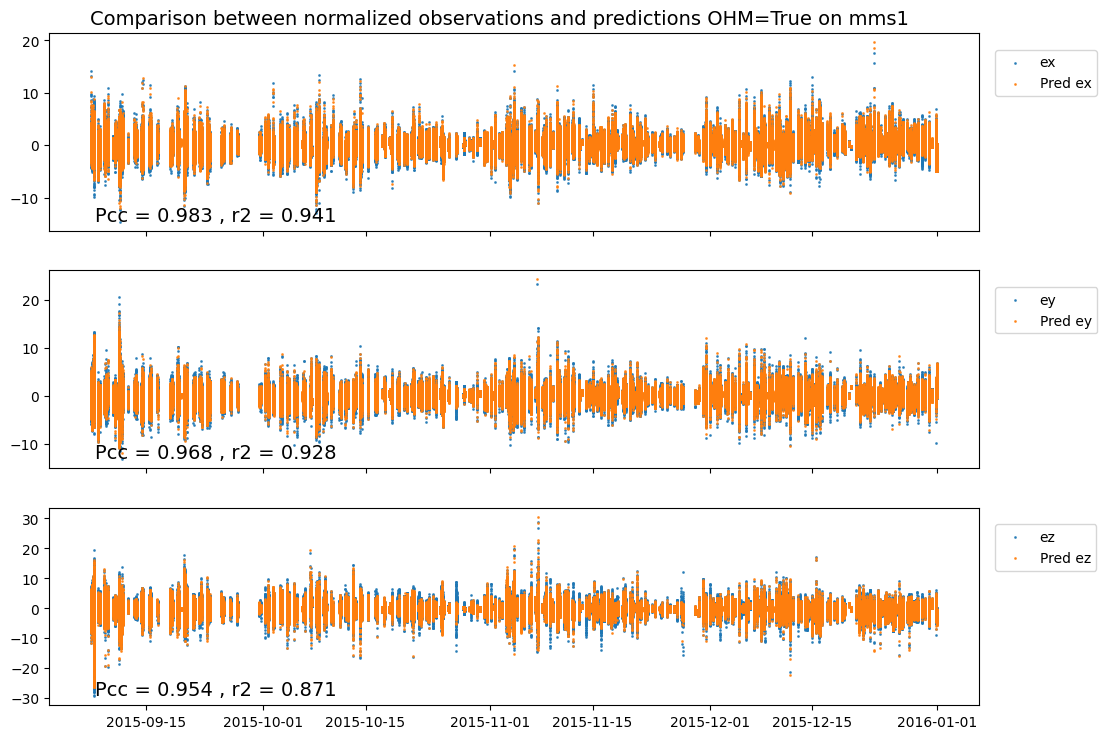

In [14]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].scatter(df_test.index,y_test[:,i],s=1, rasterized=True, label=target_labels[i],alpha=0.8)
    ax[i].scatter(df_test.index,test_predict[:,i],s=1, rasterized=True, label='Pred {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {:.3}'.format(metrics['PCC'][i])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Comparison between normalized observations and predictions OHM={OHM} on {sat}", fontsize=14)

plt.show()

In [ ]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].scatter(df_test.index, y_test[:,i]-test_predict[:,i],s=1,rasterized=True, label=target_labels[i],alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {:.3}'.format(metrics['PCC'][i])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Difference between normalized observations and predictions OHM={OHM}", fontsize=14)

plt.show()

In [17]:
# test
scale.to('cpu')
_, predict = scale.untransform(X_test,torch.Tensor(test_predict))

In [18]:
predict = torch.concatenate(scale.untransform(X_test,torch.Tensor(test_predict)),axis=1)

In [19]:
# test 
df_predict = pd.DataFrame(predict)
df_predict.columns = df_test.columns
df_predict['time'] = df_test.index
df_predict = df_predict.set_index(['time'])
df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,ex,ey,ez
time,,,,,,,,,,,,,,,,,,,
2015-09-07 13:11:04.090,8.736357,2.149989,26.757632,-5.104039e-09,1.441812e-08,-7.595027e-09,-27.086432,-50.526826,-21.368301,0.746191,1.306037,-0.538088,-0.383185,3.363562,0.587347,-1.145395,0.839218,-1.100491,-0.068114
2015-09-07 13:11:04.120,8.715878,2.139297,26.775761,-5.599547e-09,-1.842353e-08,-4.717482e-09,-27.083844,-50.370817,-21.381691,0.732904,1.302975,-0.538830,-0.381085,-4.115097,0.926684,1.265482,-0.254369,-0.758844,0.229603
2015-09-07 13:11:04.150,8.721929,2.154359,26.786959,-4.597177e-09,-5.622313e-09,3.456412e-09,-37.578130,-41.368511,-16.676524,0.782511,1.072209,-0.861152,-0.279856,-1.260656,1.222689,0.312139,0.000268,-0.946757,0.146591
2015-09-07 13:11:04.180,8.710505,2.140495,26.789248,1.781837e-08,-1.224193e-08,1.702591e-09,-48.173153,-32.272161,-11.924980,0.749300,0.839022,-1.186650,-0.177992,-2.762126,-3.852611,1.205932,-0.333199,-1.599269,0.304594
2015-09-07 13:11:04.210,8.702033,2.110985,26.797021,5.130010e-10,-2.407488e-08,-8.541148e-09,-58.579366,-23.155984,-7.134026,0.812281,0.605452,-1.507672,-0.077844,-4.818630,-0.676741,1.618108,-0.713072,-1.591105,0.459764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 23:45:43.843,14.064335,-9.138299,-52.071630,1.406666e-08,-7.038100e-09,3.076128e-09,-116.491808,-186.349902,82.970486,3.684754,-10.461752,4.898994,-3.685424,0.668396,1.314002,-0.050070,-10.257460,5.207766,-3.771177
2015-12-31 23:45:43.873,13.992611,-9.153794,-52.095586,-1.759022e-08,-9.050383e-10,5.196243e-09,-116.462796,-186.355541,82.968561,3.720845,-10.467778,4.906251,-3.673677,0.158877,-1.415199,0.291340,-10.278029,5.020948,-3.695093
2015-12-31 23:45:43.903,13.973624,-9.171409,-52.138014,-4.880774e-09,-8.807728e-09,5.567296e-09,-116.474416,-186.348310,82.968219,3.716792,-10.476766,4.913378,-3.672196,0.856895,-0.296692,0.281848,-10.218457,5.082019,-3.688126


In [21]:
df_theo = E_mhd(df_test)+E_mhd(df_test)

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(np.arange(len(df_test)),df_test.sort_index()[col], label='Observed ' + col, color='k',linestyle='solid',alpha=0.5)
        ax[j].plot(np.arange(len(df_test)),df_predict.sort_index()[col], label='Modeled ' + col, color='r',linestyle='dashed',alpha=0.5)
        #ax[j].plot(np.arange(len(df_test)),df_theo.sort_index()[col], label="Ohm's law " + col, color='g',linestyle='dotted',alpha=0.5)
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        #ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        #ax[j].set_xlim(t_test_begin, t_test_end)
        #ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        #ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        #ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        #ax[j].set_xlim(6700,6900)
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.legend(loc='center right')
fig.subplots_adjust(top=0.9,right=0.8)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(df_test.sort_index()[col]-df_predict.sort_index()[col], label='Diff ' + col, color='k')
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        #ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

In [22]:
import seaborn as sns

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot((df_test[col]-df_test[col].mean())/df_test[col].std(),ax=ax[j],stat='density',color='blue',alpha=0.5)
        sns.histplot((df_predict[col]-df_predict[col].mean())/df_predict[col].std(),ax=ax[j],stat='density',color='red',alpha=0.8)

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_xlim(-10,10)
ax[1].set_xlim(-10,10)
ax[2].set_xlim(-10,10)
plt.tight_layout()
plt.show()

In [23]:
df_res = df_test[output_targets]-df_predict[output_targets]

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot(df_res[col],ax=ax[j],stat='density',color='blue',alpha=0.8,label=col)

ax[0].set_xlim(-5,5)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)

plt.tight_layout()
plt.show()

## FFT

In [24]:
fft_ex, fft_ey, fft_ez = np.abs(np.fft.rfft(df_test['ex'])), np.abs(np.fft.rfft(df_test['ey'])),np.abs(np.fft.rfft(df_test['ez']))
fft_pred_ex, fft_pred_ey, fft_pred_ez = np.abs(np.fft.rfft(df_predict['ex'])), np.abs(np.fft.rfft(df_predict['ey'])),np.abs(np.fft.rfft(df_predict['ez']))

In [25]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [27]:
t_sampling = 0.03

freq = np.arange(len(fft_ex))/(t_sampling*len(fft_ex))

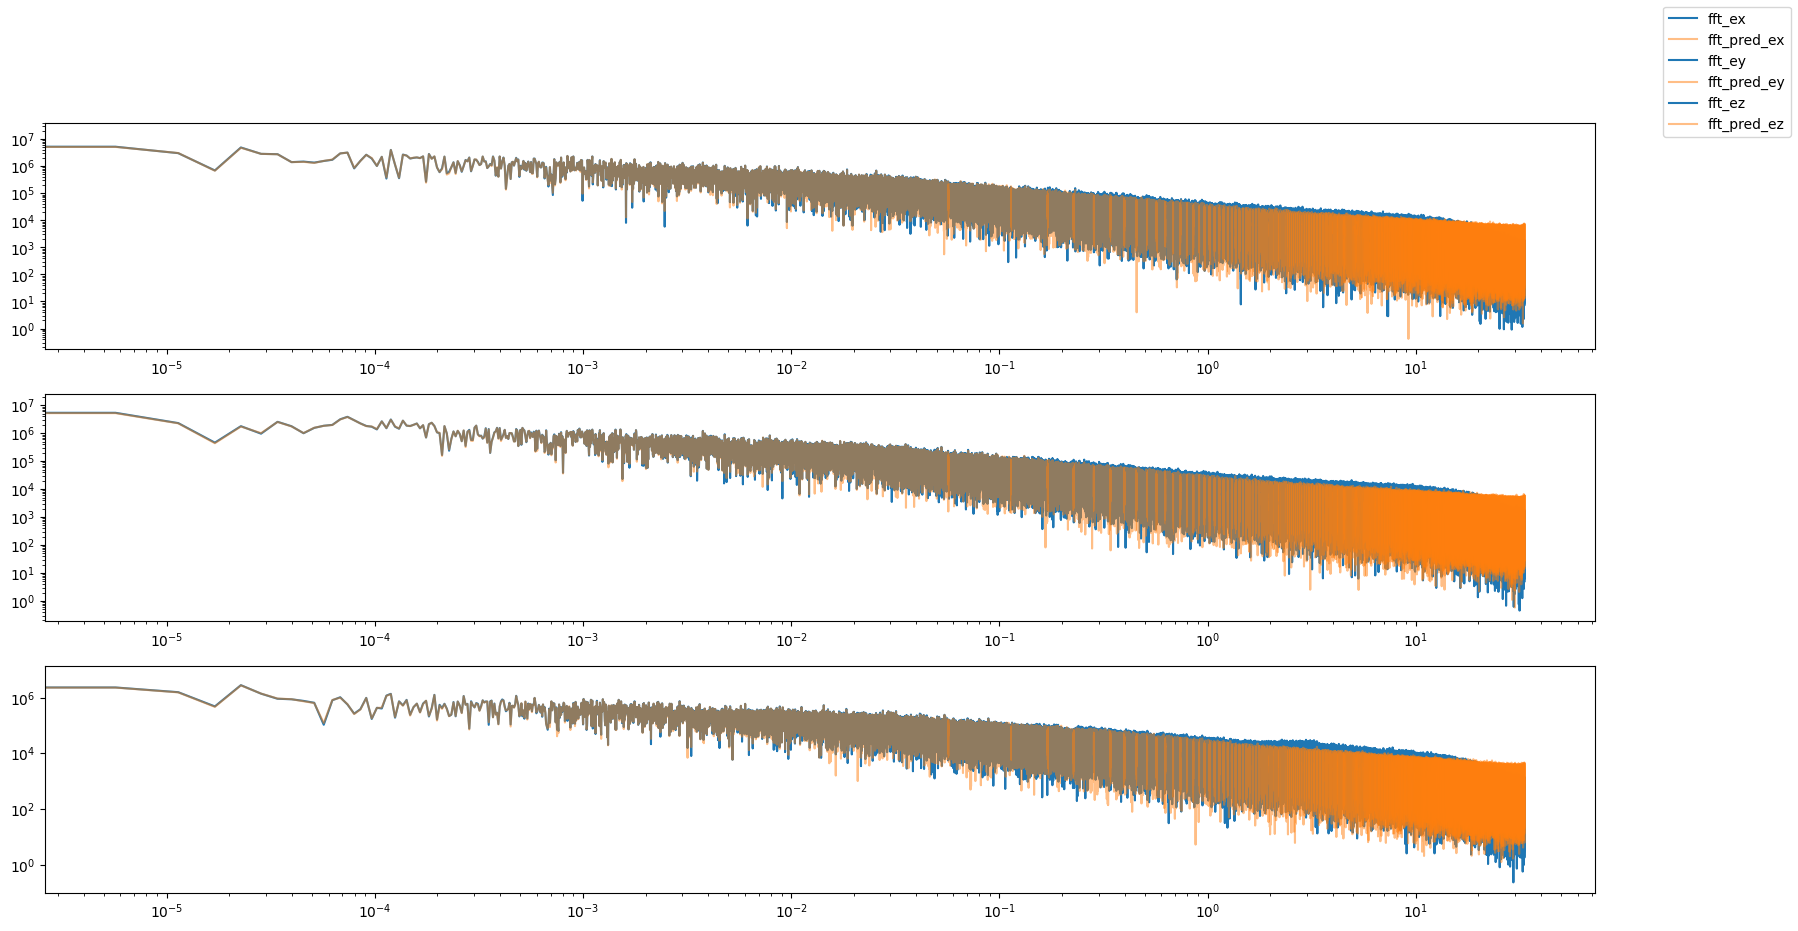

In [28]:
fig, axes = plt.subplots(nrows=3,figsize=(20,10),dpi=200)

axes[0].plot(freq,fft_ex,label='fft_ex',)
axes[0].plot(freq,fft_pred_ex,label='fft_pred_ex',alpha=0.5)

axes[0].set_xscale('log')
axes[0].set_yscale('log')

axes[1].plot(freq,fft_ey,label='fft_ey')
axes[1].plot(freq,fft_pred_ey,label='fft_pred_ey',alpha=0.5)

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[2].plot(freq,fft_ez,label='fft_ez')
axes[2].plot(freq,fft_pred_ez,label='fft_pred_ez',alpha=0.5)

axes[2].set_xscale('log')
axes[2].set_yscale('log')

fig.legend()

## Graham & al. (2017) - Lower Hybrid Waves in the Ion Diffusion and Magnetospheric Inflow Regions

In [70]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2015,12,8,0,0,0)
        t2 = datetime(2015,12,8,1,0,0)
        sat = 'mms1'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
df_test = dataset.to_dataframe()
test_data ,_ = random_split(dataset, [1,0])

t01, t02 =  datetime(2015,12,8,0,5,50), datetime(2015,12,8,0,6,30)

df_test = df_test[t01:t02]
test_data.dataset.values = test_data.dataset[np.argwhere((test_data.dataset.index > t01)&(test_data.dataset.index < t02))][:,0,:]
test_data.dataset.index = test_data.dataset.index.where((test_data.dataset.index > t01)&(test_data.dataset.index < t02)).dropna()

print(test_data.dataset.values)

scale.to('cpu')
X_test, y_test = scale.transform(test_data)
scale.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

test_graham = torch.Tensor(model.predict(X_test,batch_size))

model.summary()

metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

tensor([[-13.3088,   9.2415, -33.6671,  ...,  -3.5920,   0.3599,   1.6683],
        [-13.2762,   9.2686, -33.5891,  ...,  -3.5513,   0.3933,   1.7039],
        [-13.3333,   9.3289, -33.5378,  ...,  -3.3580,   0.4478,   1.6135],
        ...,
        [ 15.1524, -23.4333,  48.7458,  ...,  -5.0702,   6.2439,   4.1279],
        [ 15.1365, -23.4524,  48.7310,  ...,  -5.0743,   6.1224,   4.2849],
        [ 15.1280, -23.4728,  48.7148,  ...,  -5.0764,   5.9689,   4.3963]],
       dtype=torch.float64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350,498 (24.23 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,233,666 (16.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - MSE: 1.8300 - PCC: 0.9310 - loss: 0.1699 - max_error: 8.9409 - r2_score: 0.8618
{'MSE': tensor([1.8560, 1.4803, 2.1537], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9328, 0.9753, 0.8849]), 'loss': 0.16994743049144745, 'max_error': tensor([ 6.9144, 12.0213,  7.8870], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8653, 0.9428, 0.7773], device='cuda:0')}


In [71]:
df_test[['ex','ey','ez']]

,ex,ey,ez
2015-12-08 00:05:50.005,-3.592019,0.359901,1.668254
2015-12-08 00:05:50.035,-3.551289,0.393326,1.703915
2015-12-08 00:05:50.065,-3.358038,0.447763,1.613519
2015-12-08 00:05:50.095,-3.298232,0.377647,1.552703
2015-12-08 00:05:50.125,-3.223592,0.382614,1.493499
...,...,...,...
2015-12-08 00:06:29.875,-5.161299,6.165671,3.868685
2015-12-08 00:06:29.905,-5.084829,6.207656,3.969488
2015-12-08 00:06:29.935,-5.070214,6.243933,4.127925
2015-12-08 00:06:29.965,-5.074264,6.122403,4.284862


In [72]:
scale.to('cpu')
X_test = X_test.to('cpu')

_, predict = scale.untransform(X_test,test_graham)
# test 
df_predict = df_test.copy()
df_predict[['ex','ey','ez']] = predict

df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,ex,ey,ez
2015-12-08 00:05:50.005,-13.308792,9.241455,-33.667072,2.317848e-08,-3.235208e-08,9.441160e-08,5.373445,-91.408004,-27.436815,9.717711,-3.330996,-0.546059,1.166872,0.139182,-0.305824,-0.138967,-3.183154,-0.441710,1.232652
2015-12-08 00:05:50.035,-13.276153,9.268634,-33.589142,1.138932e-07,-1.664081e-08,7.821473e-08,5.411631,-90.094566,-26.966638,9.823712,-3.276143,-0.539785,1.145951,-0.105464,1.770841,0.530333,-3.289883,0.299904,1.505671
2015-12-08 00:05:50.065,-13.333344,9.328934,-33.537812,3.443306e-08,-3.612758e-08,4.388400e-08,5.507240,-88.769119,-26.490609,9.715130,-3.224251,-0.537909,1.132212,0.515407,0.365998,-0.103099,-2.900118,-0.140817,1.164697
2015-12-08 00:05:50.095,-13.307904,9.305328,-33.404641,3.638854e-08,-6.034291e-09,5.019614e-08,6.335679,-89.457082,-26.745253,9.886072,-3.237155,-0.567564,1.131531,-0.167633,0.345686,0.163078,-3.178227,-0.177273,1.301100
2015-12-08 00:05:50.125,-13.226568,9.325485,-33.347464,1.084452e-07,-6.217751e-08,6.169526e-08,7.140533,-90.116020,-27.001784,9.836635,-3.256945,-0.595260,1.125337,0.950585,1.776872,0.119866,-2.925208,0.143808,1.348262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-08 00:06:29.875,15.158445,-23.396031,48.752381,-5.588302e-09,-3.738322e-11,6.590491e-09,66.485565,30.057481,-5.763384,0.210068,-1.330533,3.328694,2.011123,4.527157,11.063041,3.901483,-3.133507,4.101484,3.149607
2015-12-08 00:06:29.905,15.136453,-23.438039,48.743324,-3.704111e-09,8.388576e-09,-2.186655e-09,70.798149,38.875830,-7.992205,0.155555,-1.707616,3.571911,2.247812,14.349885,5.916420,-1.611238,-3.892500,5.037576,3.692450
2015-12-08 00:06:29.935,15.152408,-23.433284,48.745772,7.745355e-09,1.979206e-08,-3.653296e-09,74.979442,47.681739,-10.319749,0.214310,-2.082458,3.811300,2.479508,25.604727,-12.607939,-14.020061,-4.140811,5.057279,3.845353
2015-12-08 00:06:29.965,15.136483,-23.452436,48.731003,-1.383307e-09,-3.377146e-09,-7.994995e-09,79.427154,56.914898,-12.597102,0.163928,-2.478087,4.061241,2.724252,-13.405094,-2.041037,3.181521,-4.017309,5.262614,3.964212


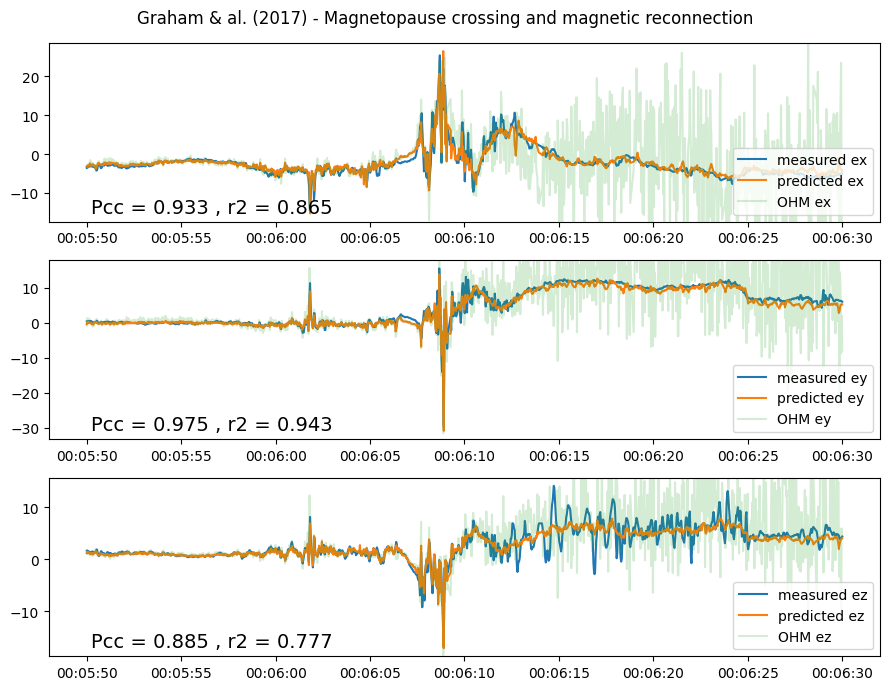

In [73]:
fig, axes = plt.subplots(nrows=3,figsize=(9,7))
for j,col in enumerate(['ex','ey','ez']):
    axes[j].plot(df_test.index,df_test[col],label=f"measured {col}")
    axes[j].plot(df_predict.index,df_predict[col],label=f"predicted {col}")
    lims = axes[j].get_ylim()
    axes[j].plot(df_predict.index,df_predict[col+"_mhd"]+df_predict[col+'_hall'],label=f"OHM {col}",alpha=0.2)
    text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][j]))
    axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
    axes[j].set_ylim(lims)
    axes[j].legend(loc=4)
    
fig.suptitle("Graham & al. (2017) - Magnetopause crossing and magnetic reconnection")
fig.tight_layout()

In [83]:
from scipy.spatial.transform import Rotation
Rot = Rotation.from_matrix(np.array([[0.25,-0.4,0.88],[0.35,-0.89,0.3],[0.9,-0.23,-0.36]]))

df_test[['eL','eM','eN']] = Rot.apply(df_test[['ex','ey','ez']])
df_predict[['eL','eM','eN']] = Rot.apply(df_predict[['ex','ey','ez']])
df_predict[['eL_mhd','eM_mhd','eN_mhd']] = Rot.apply(df_predict[['ex_mhd','ey_mhd','ez_mhd']])
df_predict[['eL_hall','eM_hall','eN_hall']] = Rot.apply(df_predict[['ex_hall','ey_hall','ez_hall']])

array([[-3.00565340e-01,  1.76701253e+00, -2.95927296e+00],
       [ 5.83455020e-01,  1.27701304e-02, -3.92684491e+00],
       [-1.74659227e-02,  1.02070072e+00, -2.71741225e+00],
       ...,
       [-3.98751596e+00,  1.61481647e-01,  2.73484186e+01],
       [ 2.90003940e-01,  3.10083592e+00, -1.67790205e+01],
       [-6.42028125e+00,  1.42199877e+01, -2.23372009e+01]])

In [106]:
r2_LMN = r2_score(df_test[['eL','eM','eN']],df_predict[['eL','eM','eN']],multioutput='raw_values')
r2_LMN_ohm = r2_score(df_test[['eL','eM','eN']],df_predict[['eL_mhd','eM_mhd','eN_mhd']].__array__()+df_predict[['eL_hall','eM_hall','eN_hall']].__array__(),multioutput='raw_values')
pcc_LMN = np.array([np.corrcoef(df_test['eL'], df_predict['eL'])[0,1],np.corrcoef(df_test['eM'], df_predict['eM'])[0,1],np.corrcoef(df_test['eN'], df_predict['eN'])[0,1]])
pcc_LMN_ohm = np.array([np.corrcoef(df_test['eL'], df_predict['eL_mhd'].__array__()+df_predict['eL_hall'].__array__())[0,1],
                        np.corrcoef(df_test['eM'], df_predict['eM_mhd'].__array__()+df_predict['eM_hall'].__array__())[0,1],
                        np.corrcoef(df_test['eN'], df_predict['eN_mhd'].__array__()+df_predict['eN_hall'].__array__())[0,1]])
print(r2_LMN)
print(r2_LMN_ohm)
print(pcc_LMN)
print(pcc_LMN_ohm)

[0.82327684 0.92533239 0.89358209]
[-1.77119093 -2.34379348 -2.58879576]
[0.90964506 0.96553266 0.94965737]
[0.55980915 0.60058352 0.48197747]


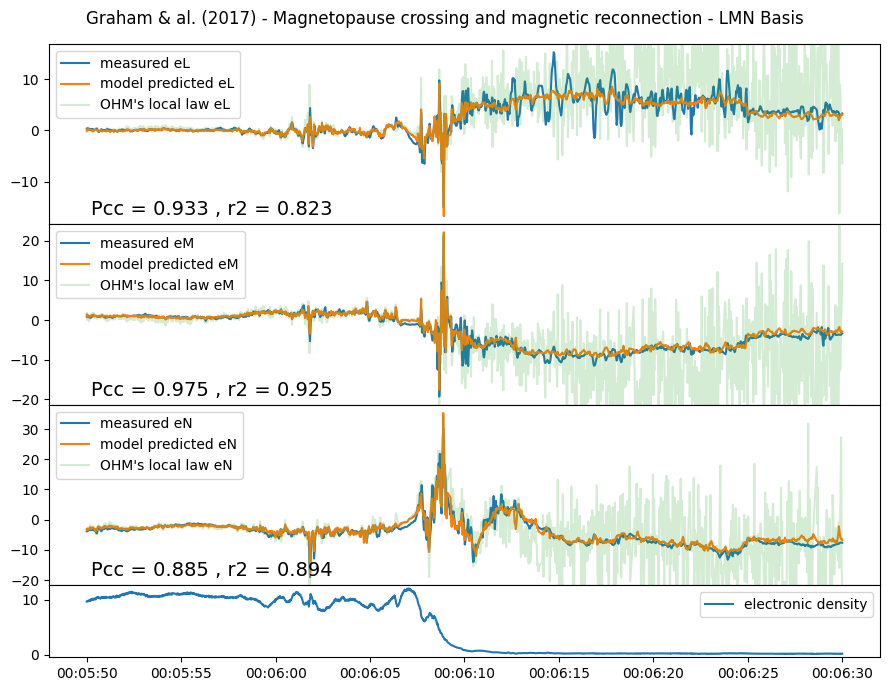

In [122]:
fig, axes = plt.subplots(nrows=4,figsize=(9,7),sharex=True,gridspec_kw={'height_ratios': [3, 3, 3, 1.2]})
for j,col in enumerate(['eL','eM','eN']):
    axes[j].plot(df_test.index,df_test[col],label=f"measured {col}")
    axes[j].plot(df_predict.index,df_predict[col],label=f"model predicted {col}")
    lims = axes[j].get_ylim()
    axes[j].plot(df_predict.index,df_predict[col+"_mhd"]+df_predict[col+'_hall'],label=f"OHM's local law {col}",alpha=0.2)
    text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(r2_LMN[j]))
    axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
    axes[j].set_ylim(lims)
    axes[j].legend(loc=2)

axes[3].plot(df_test.index,df_test['e_density'],label='electronic density')
axes[3].legend()
#axes[3].set_yscale('log')
fig.suptitle("Graham & al. (2017) - Magnetopause crossing and magnetic reconnection - LMN Basis")
fig.tight_layout()
plt.subplots_adjust(hspace=0)

## Chen, L.-J., et al. (2016), Electron energization and mixing observed by MMS in the vicinity of an electron diffusion region during magnetopause reconnection

In [32]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2015,9,19,7,0,0)
        t2 = datetime(2015,9,19,9,0,0)
        sat = 'mms2'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
df_test = dataset.to_dataframe()
test_data ,_ = random_split(dataset, [1,0])

t01, t02 =  datetime(2015,9,19,7,44,8), datetime(2015,9,19,7,44,54)

df_test = df_test[t01:t02]
test_data.dataset.values = test_data.dataset[np.argwhere((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02))][:,0,:]
test_data.dataset.index = test_data.dataset.index.where((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02)).dropna()

print(test_data.dataset.values)

scale.to('cpu')
X_test, y_test = scale.transform(test_data)
scale.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

test_chen = torch.Tensor(model.predict(X_test,batch_size))

model.summary()

metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

tensor([[  4.0151, -21.9129, -29.7498,  ...,   3.6980,   2.1493,   0.3531],
        [  3.8055, -22.3221, -29.5174,  ...,   4.2383,   2.5286,  -1.1611],
        [  3.5852, -22.2942, -29.1997,  ...,   3.8553,   3.0992,  -2.0563],
        ...,
        [ 23.0820,  -2.5789,  60.0436,  ...,  -3.2737,  -1.0829,   1.1123],
        [ 23.3277,  -2.2770,  59.8147,  ...,  -3.3875,  -0.6248,   1.3870],
        [ 23.7967,  -1.9436,  59.7278,  ...,  -2.9372,  -0.8203,   1.2383]],
       dtype=torch.float64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350,498 (24.23 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,233,666 (16.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - MSE: 6.0385 - PCC: 0.8359 - loss: 0.4936 - max_error: 13.5731 - r2_score: 0.6863
{'MSE': tensor([7.2070, 6.0593, 4.8493], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9092, 0.8748, 0.7238]), 'loss': 0.49359118938446045, 'max_error': tensor([11.5333, 14.5329, 14.6532], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8113, 0.7291, 0.5185], device='cuda:0')}


In [33]:
scale.to('cpu')
X_test = X_test.to('cpu')

_, predict = scale.untransform(X_test,test_chen)
# test 
df_predict = df_test.copy()
df_predict[['ex','ey','ez']] = predict

df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,ex,ey,ez
2015-09-19 07:44:08.000,4.015116,-21.912913,-29.749783,-2.761018e-07,2.356262e-07,-9.989397e-08,-130.327776,143.107590,-142.836238,34.415932,7.387378,4.450727,-2.281268,-1.668250,-1.562385,0.925660,5.592157,3.111045,-1.587797
2015-09-19 07:44:08.030,3.805469,-22.322144,-29.517430,-3.603428e-09,7.613700e-08,-2.984476e-07,-130.077218,142.533146,-143.572826,35.190845,7.412066,4.385907,-2.361197,-1.580179,-0.220300,-0.037122,5.972708,3.732460,-2.371898
2015-09-19 07:44:08.060,3.585211,-22.294190,-29.199731,-6.182488e-08,2.797588e-07,-3.830696e-07,-131.448531,142.447183,-144.158750,33.513653,7.373322,4.355101,-2.419835,-3.111867,-0.591986,0.069903,4.626654,3.145487,-2.001718
2015-09-19 07:44:08.090,3.879387,-22.631520,-30.146716,1.378899e-08,1.100125e-08,4.265039e-07,-132.833469,142.409431,-144.836607,33.127831,7.571049,4.566370,-2.453762,1.756099,0.390052,-0.066836,8.280984,4.852829,-1.770739
2015-09-19 07:44:08.120,3.767374,-23.279524,-30.617916,-1.534112e-07,-1.399664e-07,2.744234e-07,-134.193637,142.359787,-145.416300,33.232731,7.743982,4.656567,-2.587641,2.004693,-0.688008,0.769775,9.119914,4.571768,-1.342073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-19 07:44:53.871,22.628479,-3.359608,60.042108,-2.318838e-09,2.061782e-08,1.270382e-07,-72.498238,77.254847,-109.072822,8.467024,-4.272102,-1.884795,1.504594,1.227169,2.221718,-0.338177,-2.919368,-0.842865,1.191969
2015-09-19 07:44:53.901,22.881115,-2.977170,60.075943,4.254936e-09,5.384802e-08,4.521821e-08,-71.507407,80.475671,-107.069666,8.407333,-4.515887,-1.846002,1.628483,2.501548,0.578338,-0.924103,-2.863726,-1.389041,1.096696
2015-09-19 07:44:53.931,23.082044,-2.578871,60.043617,-7.553894e-09,2.313512e-08,1.404977e-07,-70.509337,83.721848,-105.135965,8.490384,-4.755830,-1.806883,1.750637,1.287532,2.717423,-0.378241,-3.206407,-0.575324,1.318347
2015-09-19 07:44:53.961,23.327676,-2.277013,59.814677,4.655340e-08,3.997122e-08,1.037134e-07,-68.744885,87.595192,-106.415255,8.218544,-4.997169,-1.629533,1.886859,1.995072,-0.277336,-0.788634,-3.424193,-1.336473,1.340320


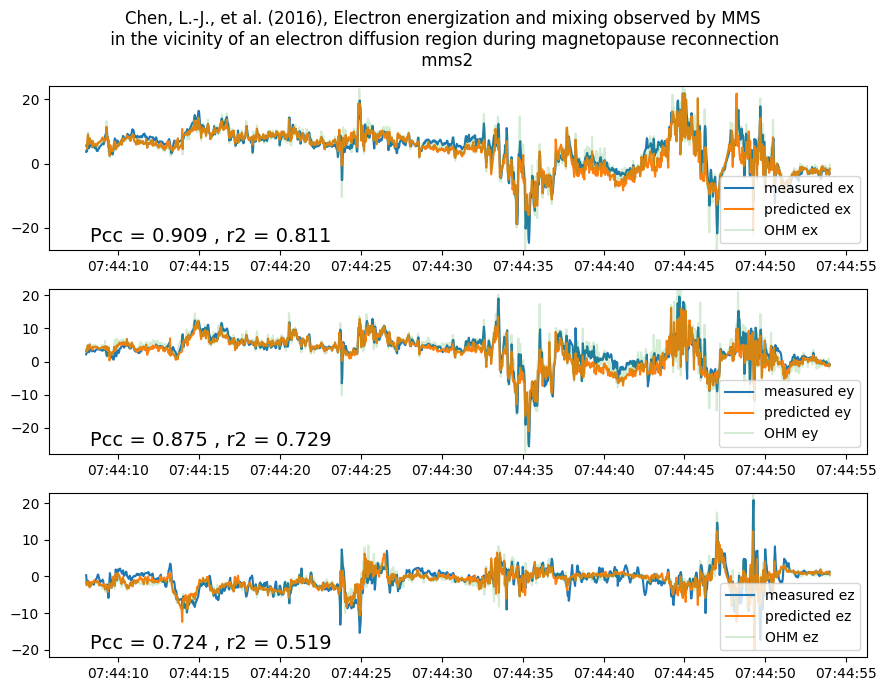

In [34]:
fig, axes = plt.subplots(nrows=3,figsize=(9,7))
for j,col in enumerate(['ex','ey','ez']):
    axes[j].plot(df_test.index,df_test[col],label=f"measured {col}")
    axes[j].plot(df_predict.index,df_predict[col],label=f"predicted {col}")
    lims = axes[j].get_ylim()
    axes[j].plot(df_predict.index,df_predict[col+"_mhd"]+df_predict[col+'_hall'],label=f"OHM {col}",alpha=0.2)
    text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][j]))
    axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
    axes[j].set_ylim(lims)
    axes[j].legend(loc=4)
    
fig.suptitle(f"Chen, L.-J., et al. (2016), Electron energization and mixing observed by MMS \n in the vicinity of an electron diffusion region during magnetopause reconnection \n {sat}")
fig.tight_layout()

## Burch et al. (2016) - Electron-scale measurements of magnetic reconnection in space

In [135]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2015,10,16,12,0,0)
        t2 = datetime(2015,10,16,14,0,0)
        sat = 'mms1'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
df_test = dataset.to_dataframe()
test_data ,_ = random_split(dataset, [1,0])

t01, t02 =  datetime(2015,10,16,13,6,30), datetime(2015,10,16,13,7,30)

df_test = df_test[t01:t02]
test_data.dataset.values = test_data.dataset[np.argwhere((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02))][:,0,:]
test_data.dataset.index = test_data.dataset.index.where((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02)).dropna()

print(test_data.dataset.values)

scale.to('cpu')
X_test, y_test = scale.transform(test_data)
scale.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

test_burch = torch.Tensor(model.predict(X_test,batch_size))

model.summary()

metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

tensor([[-10.6977,  10.1115, -24.0509,  ...,   1.8452,   2.6747,   0.4045],
        [-10.7519,  10.1455, -24.0281,  ...,   1.7991,   2.6807,   0.3612],
        [-10.8334,  10.1872, -23.9892,  ...,   1.5452,   2.3642,   0.3058],
        ...,
        [  0.1922,  23.5546,  -5.0526,  ...,  -3.1607,   0.8786,   5.4721],
        [  0.3223,  23.5485,  -4.3021,  ...,  -3.2803,   0.7549,   5.5984],
        [  0.6167,  23.7141,  -3.9457,  ...,  -3.6904,   0.8712,   6.2398]],
       dtype=torch.float64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350,498 (24.23 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,233,666 (16.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - MSE: 1.1835 - PCC: 0.8746 - loss: 0.0940 - max_error: 8.7831 - r2_score: 0.7636
{'MSE': tensor([1.2510, 1.5025, 0.7971], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8797, 0.8825, 0.8615]), 'loss': 0.0939897820353508, 'max_error': tensor([ 9.2750, 10.0381,  7.0361], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7705, 0.7783, 0.7419], device='cuda:0')}


In [36]:
scale.to('cpu')
X_test = X_test.to('cpu')

_, predict = scale.untransform(X_test,test_burch)
# test 
df_predict = df_test.copy()
df_predict[['ex','ey','ez']] = predict

df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,ex,ey,ez
2015-10-16 13:06:30.015,-10.697748,10.111502,-24.050944,4.435404e-09,-3.665571e-08,-7.519584e-08,-117.268978,105.994919,-71.151442,9.481335,1.829830,2.059269,0.051859,1.080885,0.599773,-0.228616,2.214810,2.608839,-0.170949
2015-10-16 13:06:30.045,-10.751911,10.145512,-24.028113,-2.209521e-08,3.857145e-08,-1.242428e-08,-117.149145,106.067379,-72.070220,9.477518,1.817410,2.039980,0.048111,-0.527340,-0.261660,0.125488,1.306582,1.812977,0.147147
2015-10-16 13:06:30.075,-10.833367,10.187205,-23.989182,-6.706401e-08,4.309769e-08,-4.400532e-08,-117.022928,106.163930,-72.956736,9.414769,1.803561,2.016917,0.042024,-0.388214,-0.750514,-0.143397,1.259112,1.558331,0.051658
2015-10-16 13:06:30.105,-10.930539,10.212792,-23.938044,-3.986207e-08,2.569054e-08,-5.062196e-08,-116.921561,106.268098,-73.851916,9.536656,1.789616,1.991632,0.032528,-0.064132,-0.262376,-0.082655,1.445201,1.860905,0.067059
2015-10-16 13:06:30.135,-11.020385,10.193940,-23.887345,-6.140873e-08,7.253735e-09,-1.130990e-08,-116.803467,106.372537,-74.762681,9.568745,1.778831,1.966211,0.018421,-0.037819,-0.875525,-0.356183,1.465335,1.529714,-0.088682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-16 13:07:29.865,0.051845,23.466142,-6.140989,4.768282e-08,-1.586679e-07,6.839152e-08,-189.349679,89.388684,-150.638251,12.625810,-2.985964,1.170604,4.447941,-0.311688,0.146507,0.557205,-3.036730,0.853092,4.237606
2015-10-16 13:07:29.895,0.119121,23.562023,-5.946016,9.541075e-08,-2.712108e-07,6.028718e-08,-190.192867,88.612956,-151.266457,12.590110,-3.037250,1.148909,4.491884,0.095251,0.284804,1.130490,-2.742894,0.593390,4.597567
2015-10-16 13:07:29.925,0.192156,23.554601,-5.052634,8.569866e-09,-2.441624e-07,3.970760e-08,-191.002331,87.801282,-151.891374,13.007639,-3.134113,0.994252,4.515855,0.143166,0.024438,0.119372,-2.838171,0.504927,3.975839
2015-10-16 13:07:29.955,0.322323,23.548548,-4.302098,8.780594e-08,-3.030969e-07,1.565585e-07,-191.853089,87.011935,-152.550393,12.949604,-3.218006,0.874541,4.545908,-1.148459,0.206392,1.043688,-3.416345,0.688938,4.332958


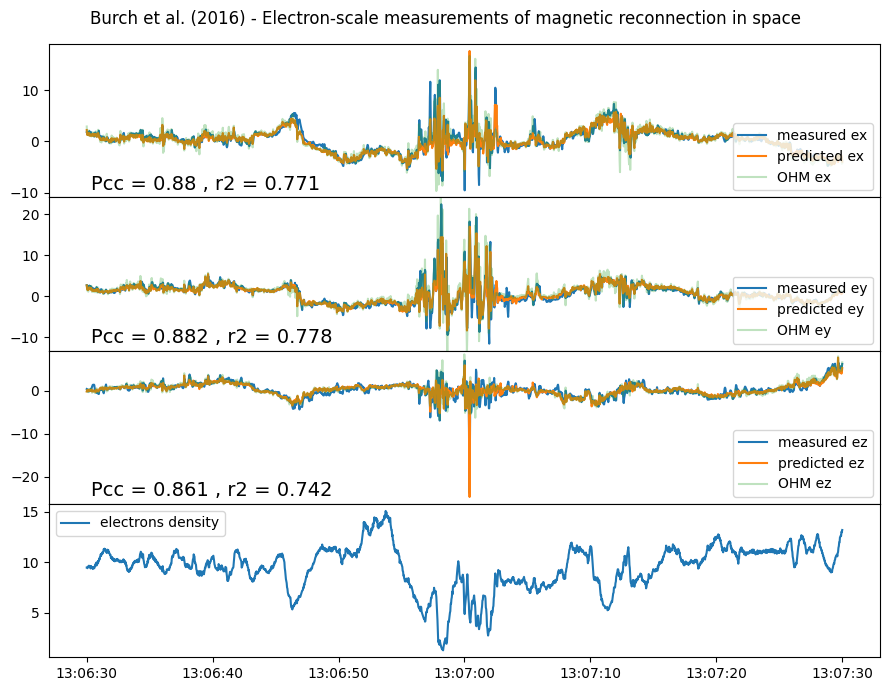

In [37]:
fig, axes = plt.subplots(nrows=4,figsize=(9,7),sharex=True)
for j,col in enumerate(['ex','ey','ez']):
    axes[j].plot(df_test.index,df_test[col],label=f"measured {col}")
    axes[j].plot(df_predict.index,df_predict[col],label=f"predicted {col}")
    lims = axes[j].get_ylim()
    axes[j].plot(df_predict.index,df_predict[col+"_mhd"]+df_predict[col+'_hall'],label=f"OHM {col}",alpha=0.3)
    text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][j]))
    axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
    axes[j].set_ylim(lims)
    axes[j].legend(loc=4)

axes[3].plot(df_test.index,df_test['e_density'],label='electrons density')
axes[3].legend()

fig.suptitle("Burch et al. (2016) - Electron-scale measurements of magnetic reconnection in space")
fig.tight_layout()
plt.subplots_adjust(hspace=0)


## Stawarz et al. (2021) - Comparative Analysis of the Various Generalized Ohm's Law Terms in Magnetosheath Turbulence as Observed by Magnetospheric Multiscale

In [624]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2016,9,28,16,50,0)
        t2 = datetime(2016,9,28,17,4,0)
        sat = 'mms1'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = './data_stawarz.hdf5'
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']
        df_stawarz= pd.DataFrame()
        n_I = []
        for j,(t1,t2) in enumerate([(datetime(2016,9,28,16,50,0),datetime(2016,9,28,17,3,0)),(datetime(2016,12,9,9,1,0),datetime(2016,12,9,9,7,0)),(datetime(2017,1,28,9,5,0),datetime(2017,1,28,9,12,0))]):
                interval = ['I1','I2','I3'][j]
                for sat in ['mms1','mms2','mms3','mms4']:
                        dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
                        df_test = dataset.to_dataframe()
                        test_data ,_ = random_split(dataset, [1,0])

                        #print(test_data.dataset.values)

                        scale.to('cpu')
                        X_test, y_test = scale.transform(test_data)
                        scale.to(device)
                        X_test, y_test = X_test.to(device) , y_test.to(device)

                        test_burch = torch.Tensor(model.predict(X_test,batch_size))

                        #model.summary()

                        metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
                        print(metrics)

                        scale.to('cpu')
                        X_test = X_test.to('cpu')

                        _, predict = scale.untransform(X_test,test_burch)
                        # test 
                        df_predict = df_test.copy()
                        df_predict[['ex','ey','ez']] = predict
                        df_stawarz_I = pd.DataFrame()
                        #df_stawarz_I[f'{interval}_{sat}_fft'] = np.absolute(np.fft.rfft((df_test[['ex','ey','ez']]+ np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3)**2,axis=0)).sum(axis=1)
                        df_stawarz_I[f'{interval}_{sat}_fft'] = np.absolute(np.fft.rfft(np.sqrt(((df_test[['ex','ey','ez']]+ np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3)**2).sum(axis=1)),axis=0))

                        #np.linalg.norm(np.fft.rfft((df_test[['ex','ey','ez']]+ np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3),axis=0),axis=1)
                        #df_stawarz_I[f'{interval}_{sat}_fft_pred'] = np.absolute(np.fft.rfft((df_predict[['ex','ey','ez']]+ np.cross(df_predict[['ux','uy','uz']].mean(),df_predict[['bx','by','bz']])/1e3)**2,axis=0)).sum(axis=1)
                        df_stawarz_I[f'{interval}_{sat}_fft_pred'] = np.linalg.norm(np.fft.rfft(df_predict[['ex','ey','ez']],axis=0),axis=1)# + np.cross(df_predict[['ux','uy','uz']].mean(),df_predict[['bx','by','bz']])/1e3),axis=1)

                        df_stawarz = pd.concat([df_stawarz,df_stawarz_I])
                        n_I.append(len(df_test))
                        print(n_I[-1])
                        print(len(df_stawarz_I[f'{interval}_{sat}_fft_pred']))
                        '''
                        fig, axes = plt.subplots(nrows=4,figsize=(9,7),sharex=True,gridspec_kw={'height_ratios': [3, 3, 3, 1.2]})
                        for j,col in enumerate(['ex','ey','ez']):
                                axes[j].plot(df_test.index,df_test[col],label=f"measured {col}")
                                axes[j].plot(df_predict.index,df_predict[col],label=f"predicted {col}")
                                lims = axes[j].get_ylim()
                                axes[j].plot(df_predict.index,df_predict[col+"_mhd"]+df_predict[col+'_hall'],label=f"OHM {col}",alpha=0.3)
                                text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][j]))
                                axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
                                axes[j].set_ylim(lims)
                                axes[j].legend(loc=4)

                                axes[3].plot(df_test.index,df_test['e_density'],label='electronic density')
                                axes[3].legend()
                                #axes[3].set_yscale('log')
                                fig.suptitle(f"Stawarz et al. (2021) - Comparative Analysis of the Various Generalized Ohm's Law Terms \n in Magnetosheath Turbulence as Observed by Magnetospheric Multiscale - {interval}/{sat}")
                                fig.tight_layout()
                                plt.subplots_adjust(hspace=0)'''


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - MSE: 7.3530 - PCC: 0.8542 - loss: 0.7904 - max_error: 25.1354 - r2_score: 0.7172


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


{'MSE': tensor([ 4.9368,  5.0899, 12.0325], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8901, 0.8976, 0.7748]), 'loss': 0.790382444858551, 'max_error': tensor([21.5652, 24.7964, 29.0447], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7811, 0.7961, 0.5745], device='cuda:0')}
26361
13181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - MSE: 2.4850 - PCC: 0.9519 - loss: 0.2416 - max_error: 16.2972 - r2_score: 0.8996


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


{'MSE': tensor([2.1587, 2.0632, 3.2331], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9539, 0.9612, 0.9408]), 'loss': 0.24160653352737427, 'max_error': tensor([13.1728, 14.2342, 21.4846], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.9021, 0.9155, 0.8811], device='cuda:0')}
26348
13175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - MSE: 6.8404 - PCC: 0.8646 - loss: 0.6938 - max_error: 26.1160 - r2_score: 0.7386


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


{'MSE': tensor([5.5656, 5.0645, 9.8912], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8772, 0.8989, 0.8178]), 'loss': 0.6938204169273376, 'max_error': tensor([25.6859, 23.8286, 28.8335], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7591, 0.8005, 0.6562], device='cuda:0')}
26384
13193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - MSE: 6.2701 - PCC: 0.8766 - loss: 0.6563 - max_error: 22.8107 - r2_score: 0.7604


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


{'MSE': tensor([4.5965, 4.5187, 9.6952], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8996, 0.9116, 0.8186]), 'loss': 0.6562634706497192, 'max_error': tensor([18.6445, 19.3640, 30.4234], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8024, 0.8231, 0.6559], device='cuda:0')}
26366
13184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - MSE: 1.8288 - PCC: 0.8885 - loss: 0.1657 - max_error: 10.7416 - r2_score: 0.7884
{'MSE': tensor([2.2572, 1.1149, 2.1142], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8894, 0.9053, 0.8706]), 'loss': 0.16573230922222137, 'max_error': tensor([14.9753,  7.6653,  9.5842], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7890, 0.8191, 0.7572], device='cuda:0')}
8126
4064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - MSE: 1.3023 - PCC: 0.9172 - loss: 0.1286 - max_error: 11.7755 - r2_score: 0.8403


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


{'MSE': tensor([1.3102, 0.7737, 1.8228], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9344, 0.9298, 0.8874]), 'loss': 0.12858140468597412, 'max_error': tensor([ 8.0632,  5.9308, 21.3325], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8701, 0.8640, 0.7869], device='cuda:0')}
8140
4071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - MSE: 1.5414 - PCC: 0.9105 - loss: 0.1392 - max_error: 11.0033 - r2_score: 0.8257
{'MSE': tensor([1.7704, 1.1315, 1.7223], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9140, 0.9143, 0.9031]), 'loss': 0.13915541768074036, 'max_error': tensor([12.1969,  7.5072, 13.3056], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8338, 0.8315, 0.8117], device='cuda:0')}
8147
4074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - MSE: 1.9260 - PCC: 0.8850 - loss: 0.1744 - max_error: 11.3510 - r2_score: 0.7801


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


{'MSE': tensor([2.0748, 1.5719, 2.1312], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8995, 0.8800, 0.8754]), 'loss': 0.17439381778240204, 'max_error': tensor([10.3500,  6.1220, 17.5809], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8032, 0.7732, 0.7640], device='cuda:0')}
8140
4071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - MSE: 0.5750 - PCC: 0.8965 - loss: 0.0546 - max_error: 8.5658 - r2_score: 0.7968
{'MSE': tensor([0.6104, 0.3859, 0.7289], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8753, 0.9465, 0.8677]), 'loss': 0.054552096873521805, 'max_error': tensor([12.1231,  7.7069,  5.8673], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7543, 0.8896, 0.7464], device='cuda:0')}
8144
4073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - MSE: 0.6414 - PCC: 0.8789 - loss: 0.0608 - max_error: 11.3326 - r2_score: 0.7631


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


{'MSE': tensor([0.6651, 0.4534, 0.8056], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8570, 0.9354, 0.8444]), 'loss': 0.060771387070417404, 'max_error': tensor([20.4623,  5.4089,  8.1265], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7214, 0.8673, 0.7005], device='cuda:0')}
8137
4069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - MSE: 0.7413 - PCC: 0.8744 - loss: 0.0684 - max_error: 9.4268 - r2_score: 0.7548
{'MSE': tensor([0.7813, 0.5792, 0.8632], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8488, 0.9252, 0.8492]), 'loss': 0.06837282329797745, 'max_error': tensor([12.9563,  8.9888,  6.3353], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7083, 0.8477, 0.7085], device='cuda:0')}
8147
4074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - MSE: 0.6983 - PCC: 0.8800 - loss: 0.0670 - max_error: 9.7625 - r2_score: 0.7626
{'MSE': tensor([0.6764, 0.5247, 0.8939], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8664, 0.9343, 0.8394]), 'loss': 0.0669761598110199, 'max_error': tensor([16.0904,  7.2177,  5.9795], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7445, 0.8634, 0.6798], device='cuda:0')}
8141
4071


array([ 3.64953339e+04,  5.36768542e+03, -2.75488712e+03, ...,
       -7.48052190e+00,  2.49683595e+01,  9.37638063e+01])

In [535]:
len(np.linalg.norm(np.fft.rfft((df_test[['ex','ey','ez']]),axis=0),axis=1))

4071

In [524]:
len(df_test[['ex','ey','ez']])

8141

In [484]:
[len(df_stawarz[col].dropna()) for col in df_stawarz.columns]

[26361,
 26361,
 26348,
 26348,
 26384,
 26384,
 26366,
 26366,
 8126,
 8126,
 8140,
 8140,
 8147,
 8147,
 8140,
 8140,
 8144,
 8144,
 8137,
 8137,
 8147,
 8147,
 8141,
 8141]

In [625]:
df_stawarz = pd.concat([df_stawarz[col].dropna()[:26361] for col in df_stawarz.columns],axis=1)
df_stawarz_2 = pd.DataFrame()
for interval in ['I1','I2','I3']:
    df_stawarz_2[f'{interval}_fft'] = df_stawarz[[f'{interval}_{sat}_fft' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)
    df_stawarz_2[f'{interval}_fft_pred'] = df_stawarz[[f'{interval}_{sat}_fft_pred' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)

In [541]:
for j in range(3):
    interval = ['I1','I2','I3'][j]
    print(np.fft.rfftfreq(n_I[::4][j],t_sampling).size)
    print(df_stawarz_2[f'{interval}_fft'].dropna().size)

13181
13193
4064
4074
4073
4074


In [632]:
freq[1]

0.008181966944853543

[0.         0.00252659 0.00505318 0.00757978]
[0.         0.00818197 0.01636393 0.0245459 ]
[0.         0.00818197 0.01636393 0.0245459 ]


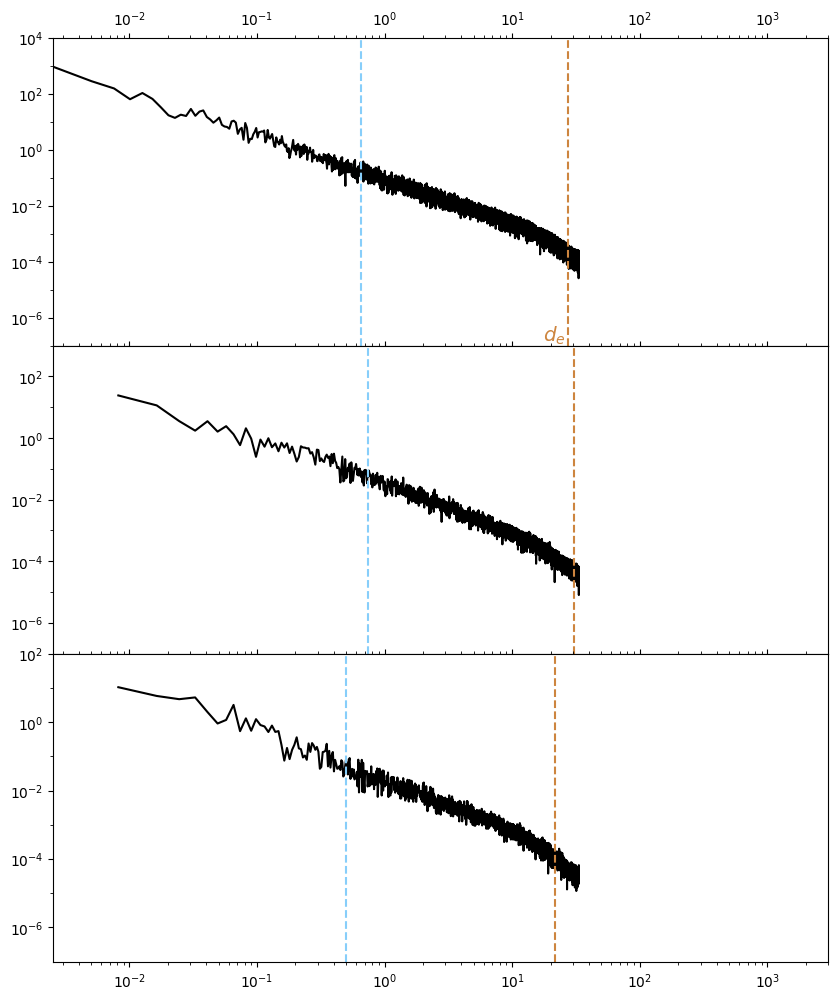

In [634]:
t_sampling = 0.03 #s

#freq = np.fft.fftfreq(len(df_stawarz_2),t_sampling)#np.arange(len(df_stawarz_2))/(t_sampling*len(df_stawarz_2))

fig, axes = plt.subplots(nrows=3,figsize=(10,12),sharex=True)
for j,ax in enumerate(axes):
    interval = ['I1','I2','I3'][j]
    n = 2*len(df_stawarz_2[f'{interval}_fft'].dropna()) - 1 
    freq = np.arange(len(df_stawarz_2[f'{interval}_fft'].dropna()))/(t_sampling*len(df_stawarz_2[f'{interval}_fft'].dropna()))
    ax.plot(freq,df_stawarz_2[f'{interval}_fft'].dropna()/(1e4*freq),color='k')
    #ax.plot(freq,df_stawarz_2[f'{interval}_fft_pred']**2/freq)
    ax.set_xscale('log')
    ax.set_yscale('log')
    print(freq[0:4])
    ax.set_yticks([1e-6,1e-4,1e-2,1e0,1e2,1e4])
    ax.set_yticks([1e-5,1e-3,1e-1,1e1,1e3],labels=['','','','',''],minor=True)
    ax.set_xticks([1e-2,1e-1,1e0,1e1,1e2,1e3])
    if j==0:
        f0 = freq[1]
        ax.tick_params(axis="x",which='both', bottom=True, top=True, labelbottom=False, labeltop=True)
    if j==1:
        ax.tick_params(axis="x",which='both', bottom=True, top=True, labelbottom=False, labeltop=False)
    if j==2:
        ax.tick_params(axis="x",which='both', bottom=True, top=True, labelbottom=True, labeltop=False)

    ax.set_xlim(left=f0,right=3e3)
    ax.set_ylim(1e-7,[1e4,1e3,1e2][j])

    ax.axvline([310/(2*np.pi*1.8),230/(2*np.pi*1.2),150/(2*np.pi*1.1)][j],linestyle='dashed',color='peru')
    ax.axvline([310/(2*np.pi*75),230/(2*np.pi*49),150/(2*np.pi*48)][j],linestyle='dashed',color='lightskyblue')

axes[0].text(310/(2*np.pi*1.8)-1,1.5e-7,'$d_e$',color='peru',fontsize='x-large',ha='right')
#axes[0].text(310/(2*np.pi*75)-1,5e-7,'$d_i$',color='lightskyblue',fontsize='x-large',ha='right')
plt.subplots_adjust(hspace=0)

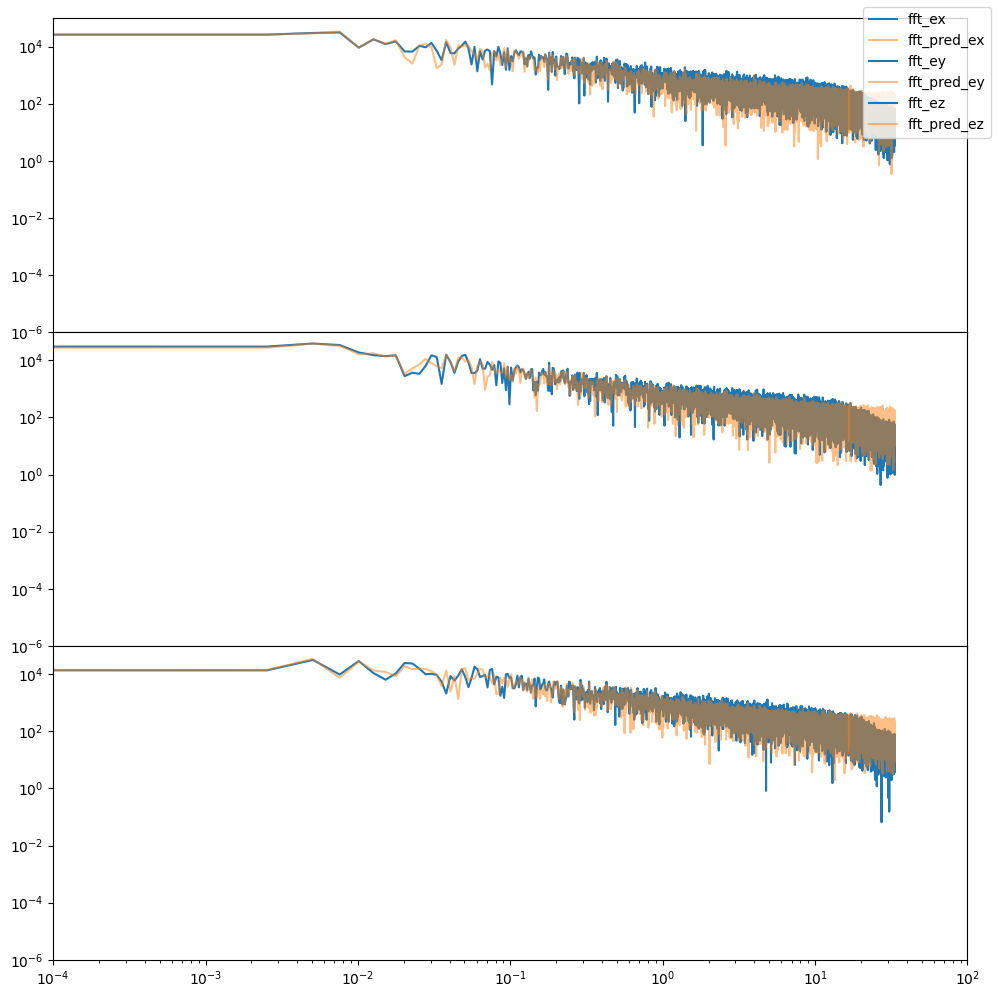

In [184]:
fft_ex, fft_ey, fft_ez = np.absolute(np.fft.rfft(df_test['ex'])), np.absolute(np.fft.rfft(df_test['ey'])),np.absolute(np.fft.rfft(df_test['ez']))
fft_pred_ex, fft_pred_ey, fft_pred_ez = np.absolute(np.fft.rfft(df_predict['ex'])), np.absolute(np.fft.rfft(df_predict['ey'])),np.abs(np.fft.rfft(df_predict['ez']))

t_sampling = 0.03

freq = np.arange(len(fft_ex))/(t_sampling*len(fft_ex))

fig, axes = plt.subplots(nrows=3,figsize=(10,10),sharex=True)

axes[0].plot(freq,fft_ex,label='fft_ex',)
axes[0].plot(freq,fft_pred_ex,label='fft_pred_ex',alpha=0.5)

axes[0].set_xscale('log')
axes[0].set_yscale('log')

axes[1].plot(freq,fft_ey,label='fft_ey')
axes[1].plot(freq,fft_pred_ey,label='fft_pred_ey',alpha=0.5)

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[2].plot(freq,fft_ez,label='fft_ez')
axes[2].plot(freq,fft_pred_ez,label='fft_pred_ez',alpha=0.5)

axes[2].set_xscale('log')
axes[2].set_yscale('log')

for ax in axes:
    ax.set_ylim(1e-6,1e5)
    ax.set_xlim(1e-4,1e2)
fig.legend()
fig.tight_layout()
plt.subplots_adjust(hspace=0)

In [299]:
keras.utils.plot_model(model)

AttributeError: module 'pydot' has no attribute 'InvocationException'